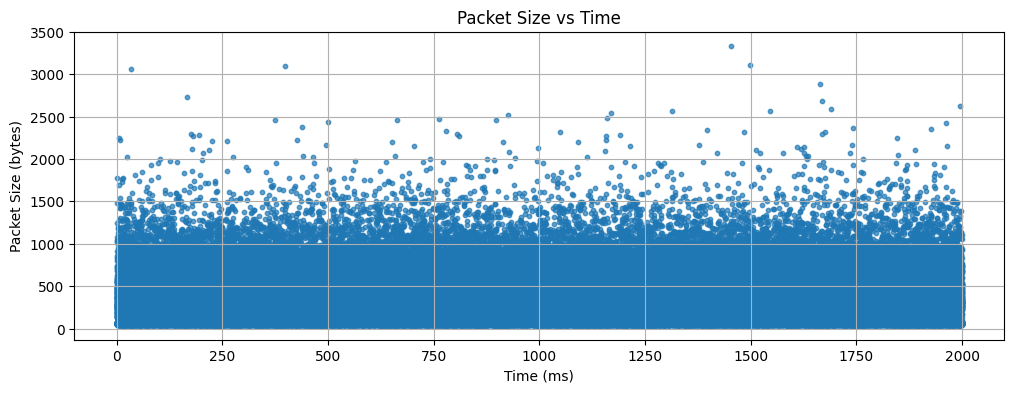

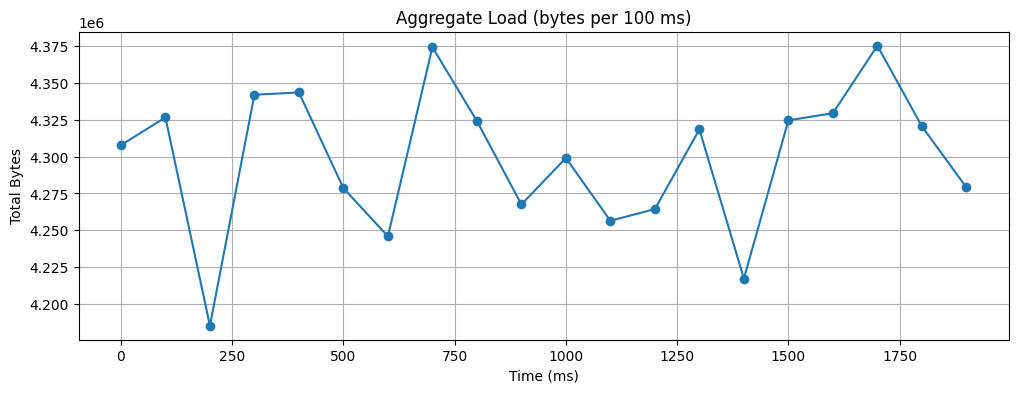

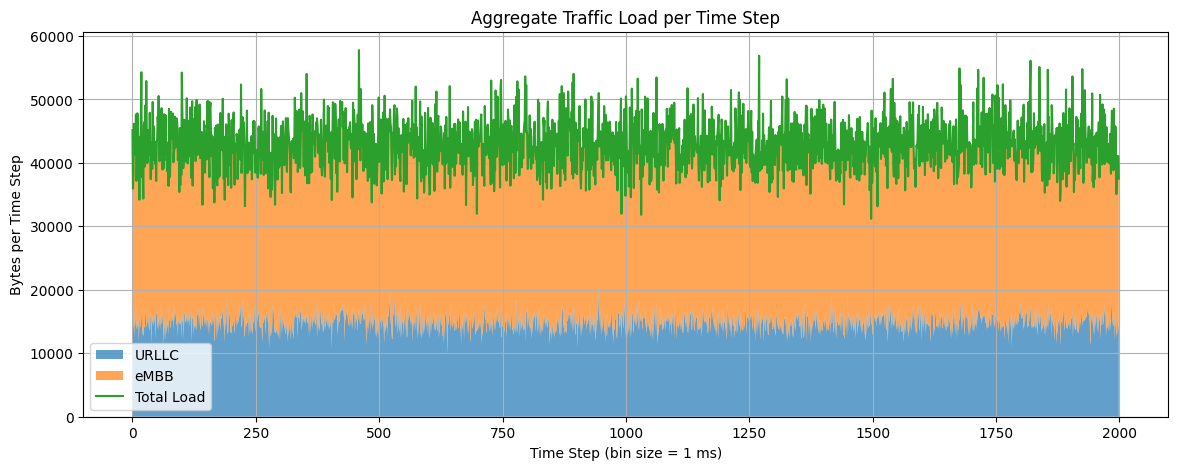

In [ ]:
# ctmc_overlap_traffic.py
# Continuous-Time Markov Chain (CTMC) traffic generator with machine overlaps.
# - CTMC over states: S0 (idle), S1, S12, S2, S23, S3
# - Active UEs per state drive which machines generate packets
# - Per-slice interarrivals: URLLC=Erlang, eMBB=Lognormal, mMTC=Weibull
# - Per-UE packet sizes: normal/lognormal/discrete (from machines_config)
# - Outputs: per-UE CSVs, all_traces.csv, timeline CSVs, and basic plots

import math
import random
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ===============================
# Reproducibility & Horizon
# ===============================
np.random.seed(11)
random.seed(11)
SIM_DURATION_MS = 2_000_000  # total simulation time in milliseconds

# ===============================
# CTMC: states and transition rates Q[state][next] = rate
# Tune these to control average dwell/overlap time.
# ===============================
states = ["S1", "S12", "S2"]


Q = {                  
    "S1":  {"S12": 0.40, "S2": 0.35},        
    "S12": {"S2": 0.20},                     
    "S2":  {"S1": 0.20},                
}


# ===============================
# Map each state -> active machines (UEs)
# Adjust to include/exclude machines in an overlap.
# ===============================
state_activity: Dict[str, List[str]] = {
    "S1":  ["M1"],          # only machining
    "S12": ["M1", "M2"],    # machining+assembly overlap
    "S2":  ["M2"],          # assembly
}

# ===============================
# UE/Machine catalog (packet sizes)
# Keep/add UEs as needed; only M1..M3 are activated above by default.
# ===============================
machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60,  "std": 5,  "ip": "10.0.0.1"},
    {"name": "M2", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5,"ip": "10.0.0.2"},
]
machines_by_name = {m["name"]: m for m in machines_config}

# ===============================
# Per-slice interarrival distributions (ms)
# URLLC -> Erlang(k, scale=mean/k)
# eMBB  -> Lognormal(mu, sigma) in log-space
# Tune to hit target loads.
# ===============================
interarrival_cfg = {
    "URLLC": {"dist": "erlang",    "k": 3, "mean_ms": 1.5},
    "eMBB":  {"dist": "lognormal", "mu": math.log(7.0), "sigma": 0.55},
}

# ===============================
# Direction mix (UL vs DL) per slice
# ===============================
uplink_ratio = {
    "URLLC": 0,
    "eMBB":  0,
}
SERVER_IP = "192.168.0.1"


# ===============================
# Sampling helpers
# ===============================
def sample_packet_size(m: Dict) -> float:
    d = m["dist"]
    if d == "normal":
        return float(max(1.0, np.random.normal(m["mean"], m["std"])))
    if d == "lognormal":
        return float(np.random.lognormal(mean=m["mean"], sigma=m["std"]))
    raise ValueError(f"Unknown size dist: {d}")

def sample_interarrival_ms_for_slice(slice_type: str) -> float:
    cfg = interarrival_cfg[slice_type]
    if cfg["dist"] == "erlang":
        k = cfg["k"]
        scale = cfg["mean_ms"] / k
        return float(np.random.gamma(shape=k, scale=scale))
    if cfg["dist"] == "lognormal":
        return float(np.random.lognormal(mean=cfg["mu"], sigma=cfg["sigma"]))
    raise ValueError(f"Unknown interarrival dist for slice {slice_type}")

def sample_direction(machine_ip: str, slice_type: str):
    if random.random() < uplink_ratio[slice_type]:
        return "UL", machine_ip, SERVER_IP
    else:
        return "DL", SERVER_IP, machine_ip


# ===============================
# CTMC simulation
# ===============================
def simulate_ctmc(Q: Dict[str, Dict[str, float]], start_state: str, t_end: float) -> List[Tuple[str, float, float]]:
    """
    Simulate CTMC path until t_end.
    Returns list of segments (state, start_ms, end_ms).
    """
    timeline: List[Tuple[str, float, float]] = []
    state = start_state
    t = 0.0

    while t < t_end:
        rates = Q.get(state, {})
        if not rates:
            timeline.append((state, t, t_end))
            break

        total = sum(rates.values())
        dwell = np.random.exponential(1.0 / total)
        seg_end = min(t + dwell, t_end)
        timeline.append((state, t, seg_end))
        t = seg_end
        if t >= t_end:
            break

        next_states = list(rates.keys())
        probs = np.array([rates[s] / total for s in next_states], dtype=float)
        state = np.random.choice(next_states, p=probs)

    return timeline

def extract_activity_intervals(timeline: List[Tuple[str, float, float]],
                               state_activity: Dict[str, List[str]]) -> Dict[str, List[Tuple[float, float]]]:
    """
    Build { UE_name: [(start_ms, end_ms), ...] } from CTMC segments.
    """
    intervals: Dict[str, List[Tuple[float, float]]] = {}
    for st, t0, t1 in timeline:
        for ue in state_activity.get(st, []):
            intervals.setdefault(ue, []).append((t0, t1))
    return intervals

def generate_packets(intervals: Dict[str, List[Tuple[float, float]]]) -> List[Dict]:
    """
    For each UE and its active intervals, simulate a renewal arrival process and packet sizes.
    """
    rows = []
    for ue, spans in intervals.items():
        m = machines_by_name.get(ue)
        if not m:
            continue
        slice_type = m["slice"]
        for (start_ms, end_ms) in spans:
            t = start_ms
            while True:
                t += sample_interarrival_ms_for_slice(slice_type)
                if t > end_ms:
                    break
                size = sample_packet_size(m)
                direction, src, dst = sample_direction(m["ip"], slice_type)
                rows.append({
                    "Time": round(t, 3),
                    "machine": ue,
                    "slice": slice_type,
                    "direction": direction,
                    "Source": src,
                    "Destination": dst,
                    "Length": round(size, 2),
                })
    return rows


# ===============================
# Main
# ===============================
def main():
    # 1) CTMC path
    timeline = simulate_ctmc(Q, start_state="S1", t_end=SIM_DURATION_MS)

    # 2) Active intervals per UE
    activity = extract_activity_intervals(timeline, state_activity)

    # 3) Generate packets
    packet_rows = generate_packets(activity)
    trace_df = pd.DataFrame(packet_rows).sort_values(["Time", "machine"]).reset_index(drop=True)

    # 4) Save outputs
    timeline_df = pd.DataFrame(timeline, columns=["state", "start_ms", "end_ms"])
    intervals_df = pd.DataFrame(
        [{"machine": ue, "start_ms": a, "end_ms": b} for ue, spans in activity.items() for (a, b) in spans]
    )
    
    # ✅ Convert ms → sec
    for df in [timeline_df, intervals_df, trace_df]:
        for col in df.columns:
            if col.endswith("_ms") or col == "Time":
                df[col] = df[col] / 1000.0

    timeline_df.to_csv("ctmc_timeline_sec.csv", index=False)
    intervals_df.to_csv("ue_activity_intervals_sec.csv", index=False)
    trace_df.to_csv("all_traces_sec.csv", index=False)

    for (slice_type, machine), grp in trace_df.groupby(["slice", "machine"]):
        grp.to_csv(f"{slice_type}_{machine}_trace_sec.csv", index=False)

# if __name__ == "__main__":
#     main()


In [ ]:
if __name__ == "__main__":
    main()


In [2]:
import random
import pandas as pd


trace_df = pd.read_csv("all_traces_sec.csv")

# 1. Build global time axis using all unique times
time_axis = pd.Series(sorted(trace_df["Time"].unique()))

# 2. Per-machine alignment
for (slice_type, machine), group in trace_df.groupby(["slice", "machine"]):
    # Use time as index
    df = group.set_index("Time").sort_index()

    # Reindex to global axis (preserves fractional times)
    df = df.reindex(time_axis)

    # Restore time column
    df = df.reset_index().rename(columns={"index": "Time"})

    # Fill fixed columns
    df["machine"] = machine
    df["slice"] = slice_type

    # Fill Length: NaN → 0
    df["Length"] = df["Length"].fillna(0)

    # Fill direction: keep real values, randomize only when missing
    directions = ["UL", "DL"]
    df["direction"] = df.apply(
        lambda row: row["direction"] if pd.notna(row["direction"]) 
        else random.choice(directions),
        axis=1
    )

    # Fill IPs: keep real, assign when missing
    machine_ip = machines_config[[m["name"] for m in machines_config].index(machine)]["ip"]
    server_ip = "192.168.0.1"
    def assign_ips(row):
        if pd.notna(row["Source"]) and pd.notna(row["Destination"]):
            return row["Source"], row["Destination"]
        if row["direction"] == "UL":
            return machine_ip, server_ip
        else:
            return server_ip, machine_ip

    df[["Source", "Destination"]] = df.apply(assign_ips, axis=1, result_type="expand")

    # Save aligned CSV
    fname = f"{slice_type}_{machine}_aligned_trace_sec.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with {len(df)} rows (aligned to global axis)")


Saved URLLC_M1_aligned_trace_sec.csv with 619525 rows (aligned to global axis)
Saved eMBB_M2_aligned_trace_sec.csv with 619525 rows (aligned to global axis)


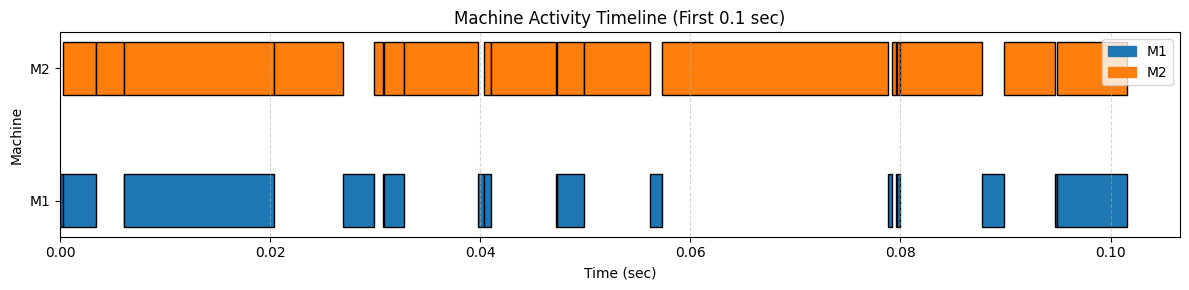

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load intervals (already in seconds)
activity_df = pd.read_csv("ue_activity_intervals_sec.csv")

# --- zoom window (set as you like) ---
ZOOM_END = 0.1     # seconds (for first 0.1 s)
activity_df = activity_df[activity_df["start_ms"] <= ZOOM_END]

# --- Assign colors per machine ---
machine_colors = {
    "M1": "#1f77b4",  # blue
    "M2": "#ff7f0e",  # orange
}

plt.figure(figsize=(12, 3))
for i, (machine, group) in enumerate(sorted(activity_df.groupby("machine"))):
    for _, row in group.iterrows():
        plt.barh(
            y=i,
            width=row["end_ms"] - row["start_ms"],
            left=row["start_ms"],
            color=machine_colors.get(machine, "gray"),
            edgecolor="black",
            height=0.4,
        )

# --- Formatting ---
plt.yticks(range(len(machine_colors)), machine_colors.keys())
plt.xlabel("Time (sec)")
plt.ylabel("Machine")
plt.title(f"Machine Activity Timeline (First {ZOOM_END} sec)")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

# Legend
handles = [mpatches.Patch(color=c, label=m) for m, c in machine_colors.items()]
plt.legend(handles=handles, loc="upper right")

plt.show()


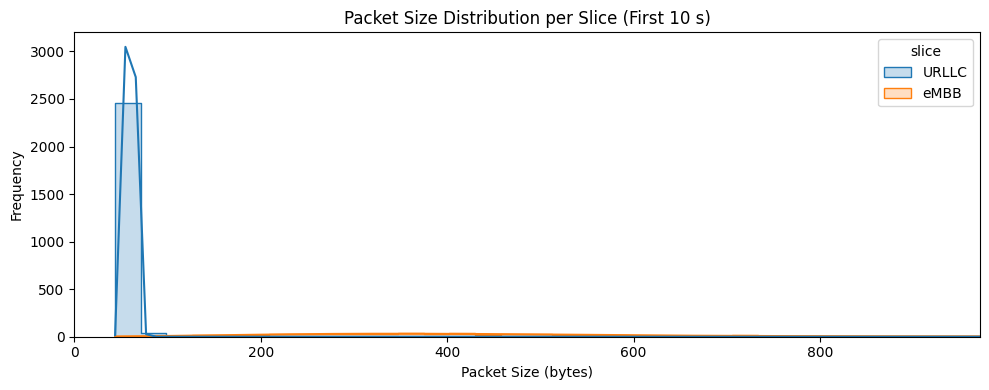

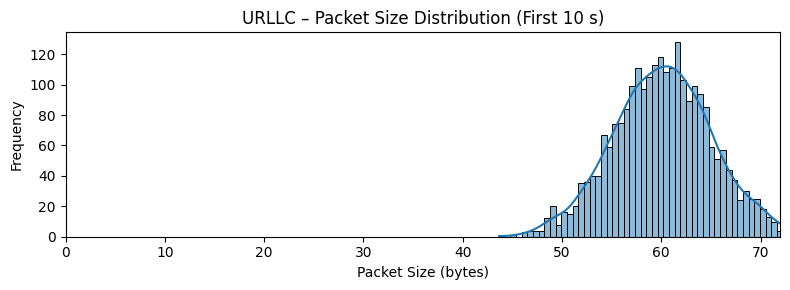

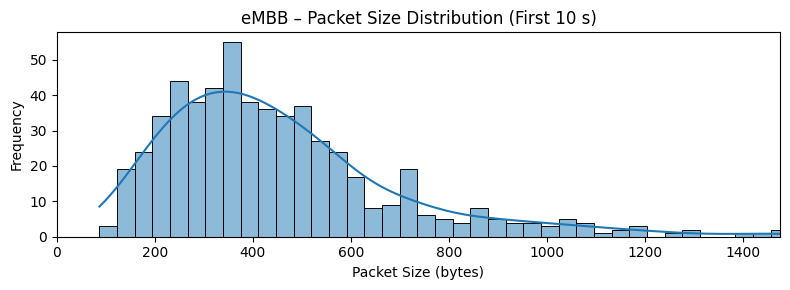

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

trace_df = pd.read_csv("all_traces_sec.csv")

# --- zoom window ---
ZOOM_END = 10  # seconds, same as activity plot
trace_zoom = trace_df[trace_df["Time"] <= ZOOM_END]

# --- combined distribution (all slices together) ---
plt.figure(figsize=(10, 4))
sns.histplot(data=trace_zoom, x="Length", hue="slice", bins=80, kde=True, element="step")
plt.title(f"Packet Size Distribution per Slice (First {ZOOM_END} s)")
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Frequency")
plt.xlim(0, trace_zoom["Length"].quantile(0.99))  # cut off extreme tail
plt.tight_layout()
plt.show()

# --- per-slice distributions separately ---
for slice_type, group in trace_zoom.groupby("slice"):
    plt.figure(figsize=(8, 3))
    sns.histplot(group["Length"], bins=60, kde=True, color="C0")
    plt.title(f"{slice_type} – Packet Size Distribution (First {ZOOM_END} s)")
    plt.xlabel("Packet Size (bytes)")
    plt.ylabel("Frequency")
    plt.xlim(0, group["Length"].quantile(0.99))
    plt.tight_layout()
    plt.show()


In [ ]:
### Inter arrival times per slice analysis

### The effect of alpha and beta (dwell time)

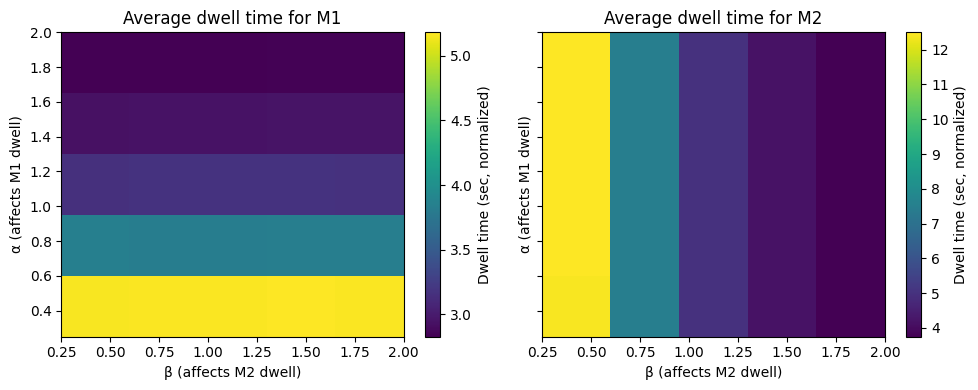

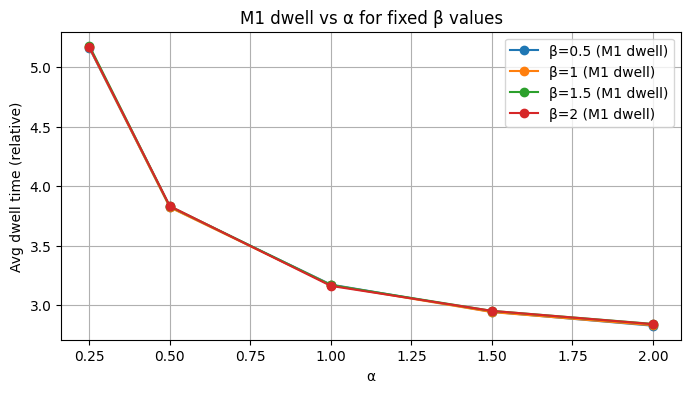

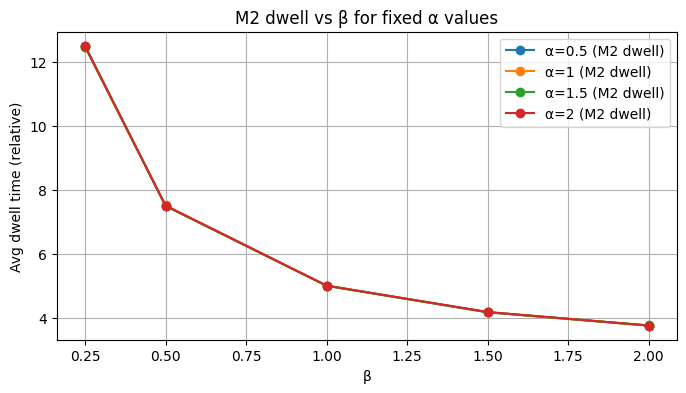

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(11)

SIM_DURATION_MS = 2_000_000
alphas = [0.25, 0.5, 1, 1.5, 2]
betas  = [0.25, 0.5, 1, 1.5, 2]
state_activity = {"S1": ["M1"], "S12": ["M1", "M2"], "S2": ["M2"]}

def simulate_ctmc(Q, start_state="S1", t_end=SIM_DURATION_MS):
    timeline = []
    state = start_state
    t = 0.0
    while t < t_end:
        rates = Q.get(state, {})
        total = sum(rates.values())
        dwell = np.random.exponential(1.0 / total)
        end_t = min(t + dwell, t_end)
        timeline.append((state, dwell))
        t = end_t
        if t >= t_end:
            break
        next_states = list(rates.keys())
        probs = np.array([rates[s] / total for s in next_states])
        state = np.random.choice(next_states, p=probs)
    return pd.DataFrame(timeline, columns=["state", "dwell"])

def avg_dwell_for_machines(df):
    dwell = {"M1": 0, "M2": 0}
    total = df.groupby("state")["dwell"].mean().to_dict()
    dwell["M1"] = np.mean([total.get("S1",0), total.get("S12",0)])
    dwell["M2"] = np.mean([total.get("S2",0), total.get("S12",0)])
    return dwell

results = []

for a in alphas:
    for b in betas:
        Q = {
            "S1":  {"S12": a * 0.40, "S2": a * 0.35},
            "S12": {"S2": 0.20},
            "S2":  {"S1": b * 0.20},
        }
        timeline = simulate_ctmc(Q)
        dwell = avg_dwell_for_machines(timeline)
        results.append({"alpha": a, "beta": b, **dwell})

res_df = pd.DataFrame(results)

# --- Plot dwell times vs alpha and beta ---
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for m, ax in zip(["M1", "M2"], axes):
    pivot = res_df.pivot(index="alpha", columns="beta", values=m)
    im = ax.imshow(pivot, origin="lower", aspect="auto", cmap="viridis",
                   extent=[min(betas), max(betas), min(alphas), max(alphas)])
    ax.set_xlabel("β (affects M2 dwell)")
    ax.set_ylabel("α (affects M1 dwell)")
    ax.set_title(f"Average dwell time for {m}")
    fig.colorbar(im, ax=ax, label="Dwell time (sec, normalized)")
plt.tight_layout()
plt.show()

# --- 1D line plots for clearer view ---
plt.figure(figsize=(8,4))
for b in [0.5, 1, 1.5, 2]:
    subset = res_df[res_df["beta"]==b]
    plt.plot(subset["alpha"], subset["M1"], marker="o", label=f"β={b} (M1 dwell)")
plt.title("M1 dwell vs α for fixed β values")
plt.xlabel("α")
plt.ylabel("Avg dwell time (relative)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
for a in [0.5, 1, 1.5, 2]:
    subset = res_df[res_df["alpha"]==a]
    plt.plot(subset["beta"], subset["M2"], marker="o", label=f"α={a} (M2 dwell)")
plt.title("M2 dwell vs β for fixed α values")
plt.xlabel("β")
plt.ylabel("Avg dwell time (relative)")
plt.legend()
plt.grid(True)
plt.show()
